In [2]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    mean_squared_error,
    ConfusionMatrixDisplay,
)
from sklearn.inspection import permutation_importance
from sklearn import tree
import matplotlib.pyplot as plt

C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")

datos = pd.read_csv(f"{path}/Sleep_health_and_lifestyle_dataset.csv")
df = datos.drop(columns=['Person ID'])

100%|██████████| 2.54k/2.54k [00:00<?, ?B/s]

Extracting files...


In [4]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [6]:
df.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


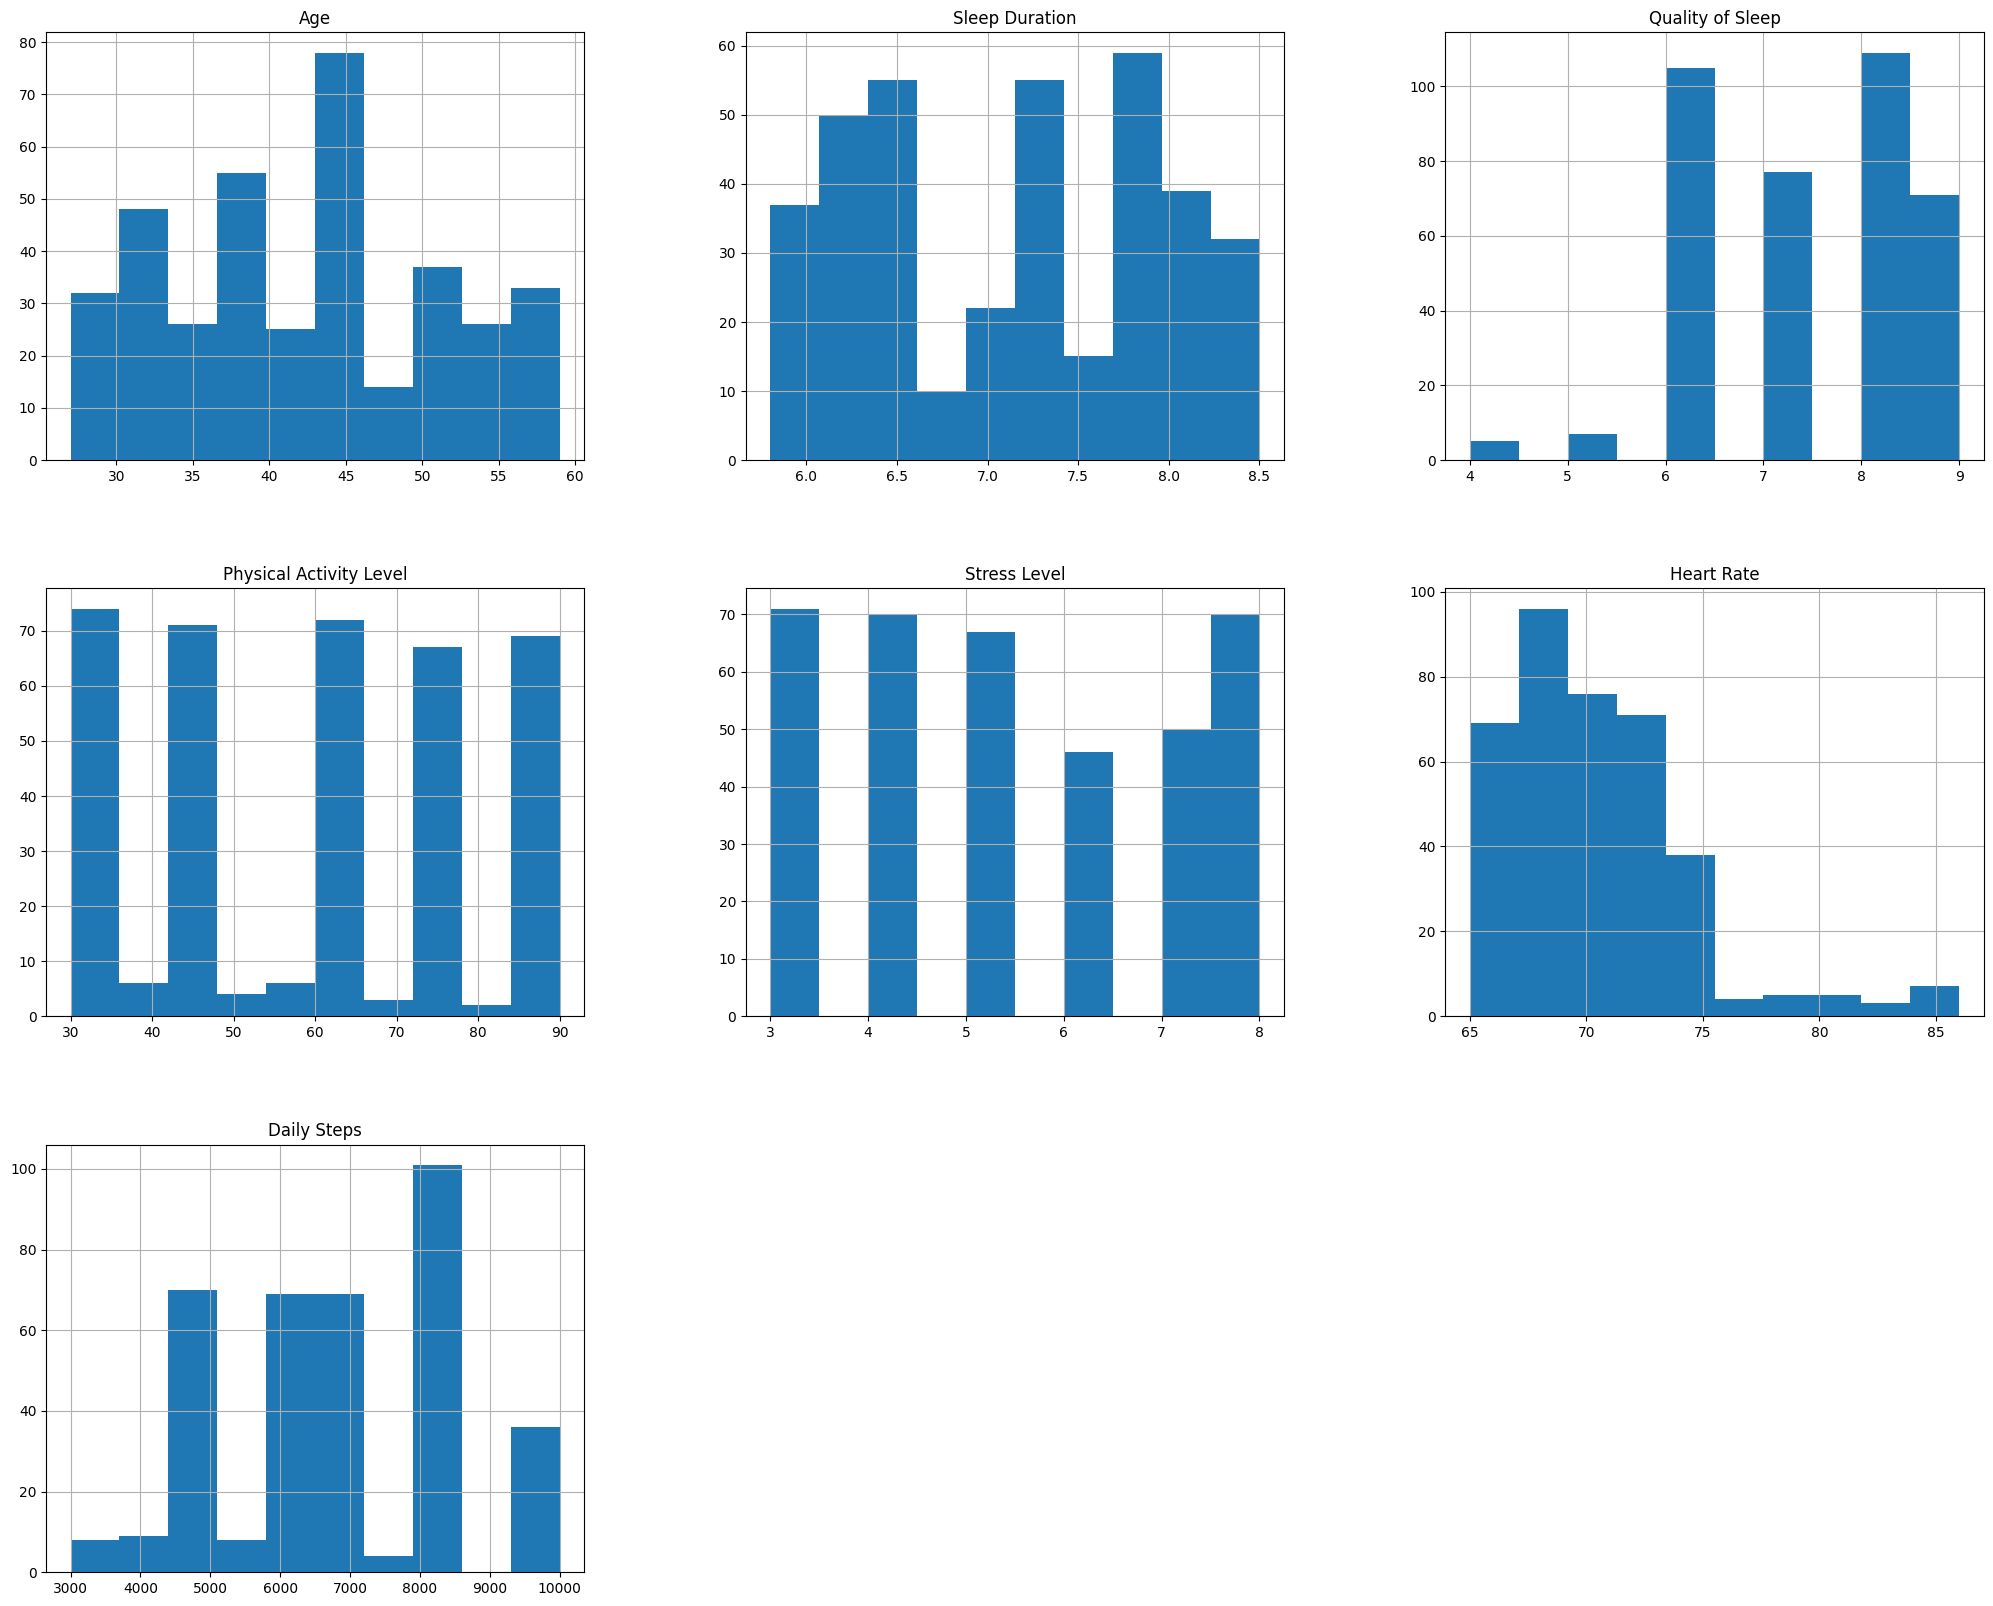

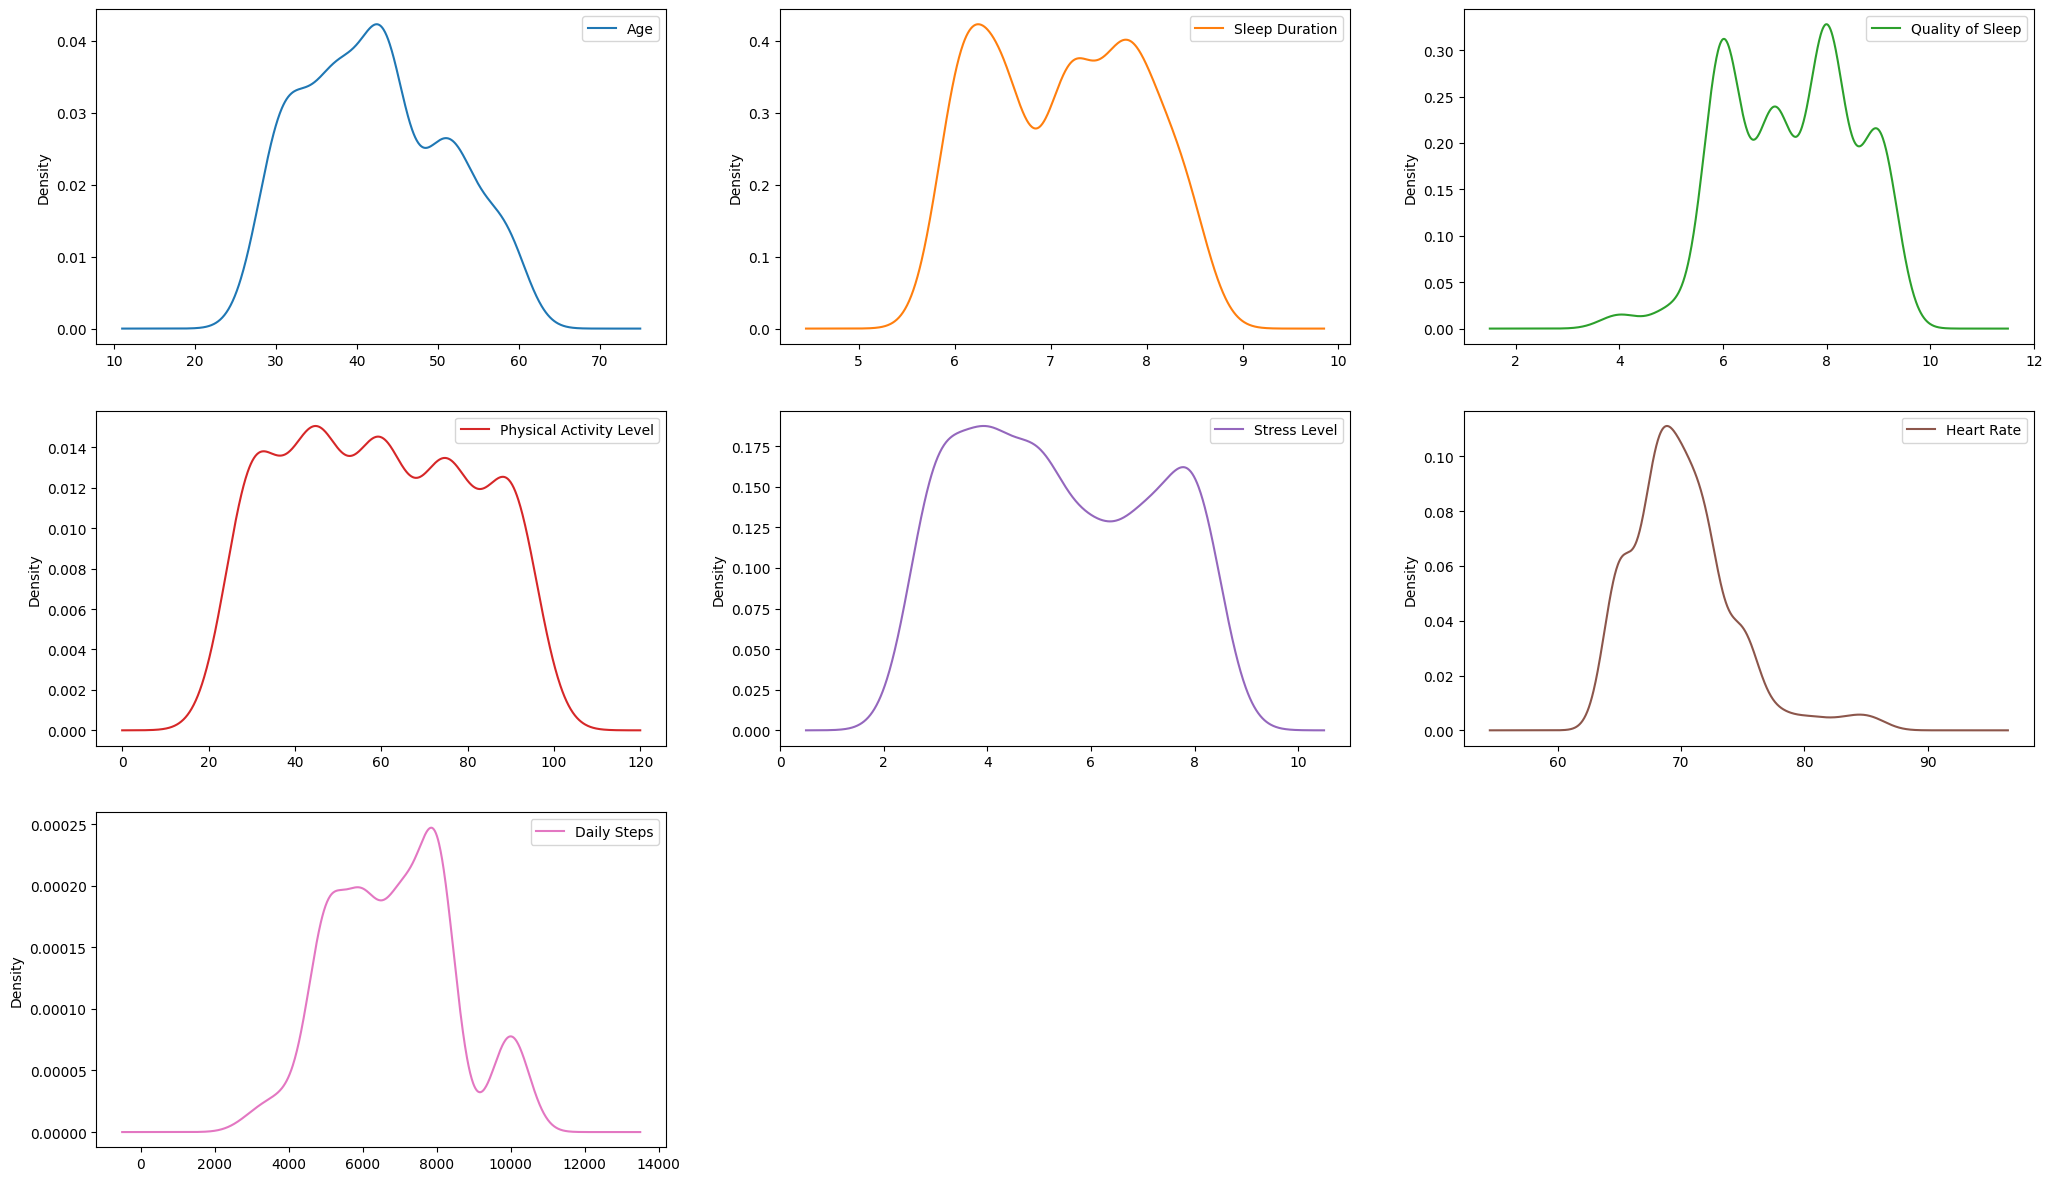

In [10]:
df_numericas = df.select_dtypes(include=[np.number])

df_numericas.hist(figsize=(25, 20))
plt.show()

df_numericas.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(25, 20))
plt.show()

In [11]:
df = datos.drop(columns=['Person ID'])
df.head()


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [12]:
df['Sleep Disorder'].value_counts()

Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

In [13]:
df['BMI Category'].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

In [14]:
df['Sleep Disorder']=df['Sleep Disorder'].fillna('None')
df['Sleep Disorder'].value_counts()

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

In [15]:
mapping_binary = {'None': 0, 'Insomnia': 1, 'Sleep Apnea': 1}

df['Sleep Disorder_cod'] = df['Sleep Disorder'].map(mapping_binary)

print(df[['Sleep Disorder_cod']].value_counts())

Sleep Disorder_cod
0                     219
1                     155
Name: count, dtype: int64


In [16]:
orden_BMI = ['Normal Weight', 'Normal', 'Overweight', 'Obese']

mapping = {ocup: idx for idx, ocup in enumerate(orden_BMI)}

df['BMI Category_cod'] = df['BMI Category'].map(mapping)
print(df[['BMI Category', 'BMI Category_cod']].value_counts())

BMI Category   BMI Category_cod
Normal         1                   195
Overweight     2                   148
Normal Weight  0                    21
Obese          3                    10
Name: count, dtype: int64


In [17]:
le = LabelEncoder()
df['Gender_cod'] = le.fit_transform(df['Gender'])
df['Occupation_cod'] = le.fit_transform(df['Occupation'])

print('\n', df[['Gender', 'Gender_cod']].value_counts())
print('\n', df[['Occupation', 'Occupation_cod']].value_counts())


 Gender  Gender_cod
Male    1             189
Female  0             185
Name: count, dtype: int64

 Occupation            Occupation_cod
Nurse                 5                 73
Doctor                1                 71
Engineer              2                 63
Lawyer                3                 47
Teacher               10                40
Accountant            0                 37
Salesperson           7                 32
Scientist             8                  4
Software Engineer     9                  4
Sales Representative  6                  2
Manager               4                  1
Name: count, dtype: int64


In [18]:
df.drop(columns=['Gender','Occupation','BMI Category','Sleep Disorder'],inplace=True)
df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder_cod,BMI Category_cod,Gender_cod,Occupation_cod
0,27,6.1,6,42,6,126/83,77,4200,0,2,1,9
1,28,6.2,6,60,8,125/80,75,10000,0,1,1,1
2,28,6.2,6,60,8,125/80,75,10000,0,1,1,1
3,28,5.9,4,30,8,140/90,85,3000,1,3,1,6
4,28,5.9,4,30,8,140/90,85,3000,1,3,1,6


In [19]:
df[['systolic', 'diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.drop(columns=['Blood Pressure'])
df.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder_cod,BMI Category_cod,Gender_cod,Occupation_cod,systolic,diastolic
0,27,6.1,6,42,6,77,4200,0,2,1,9,126,83
1,28,6.2,6,60,8,75,10000,0,1,1,1,125,80
2,28,6.2,6,60,8,75,10000,0,1,1,1,125,80
3,28,5.9,4,30,8,85,3000,1,3,1,6,140,90
4,28,5.9,4,30,8,85,3000,1,3,1,6,140,90


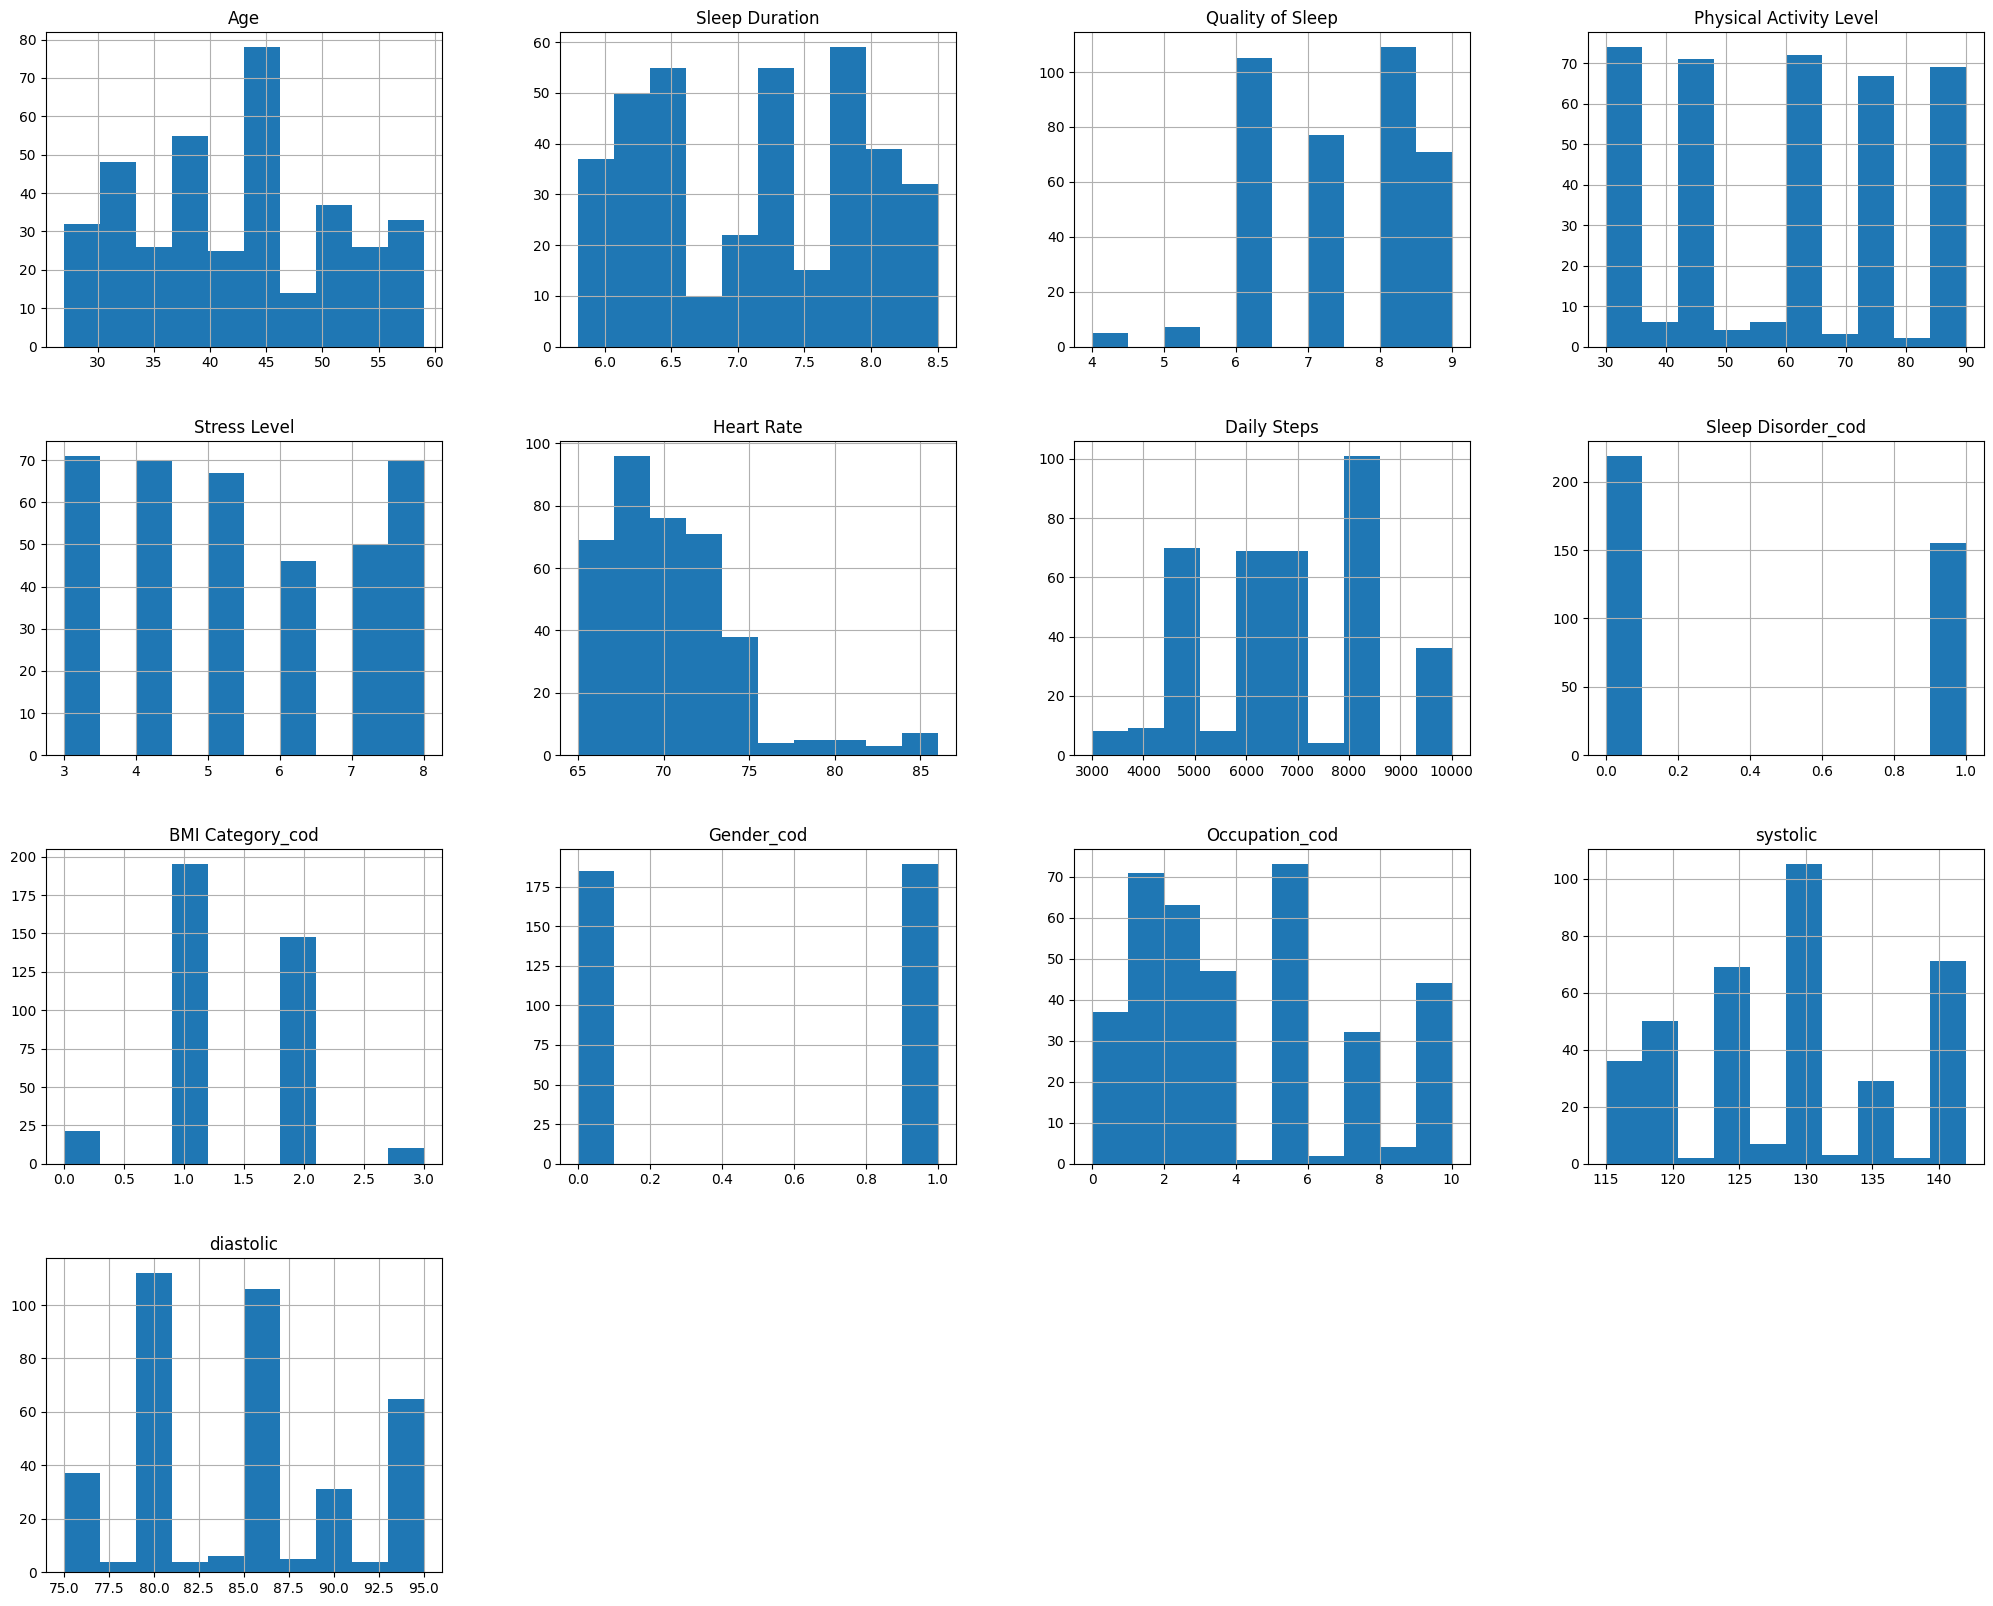

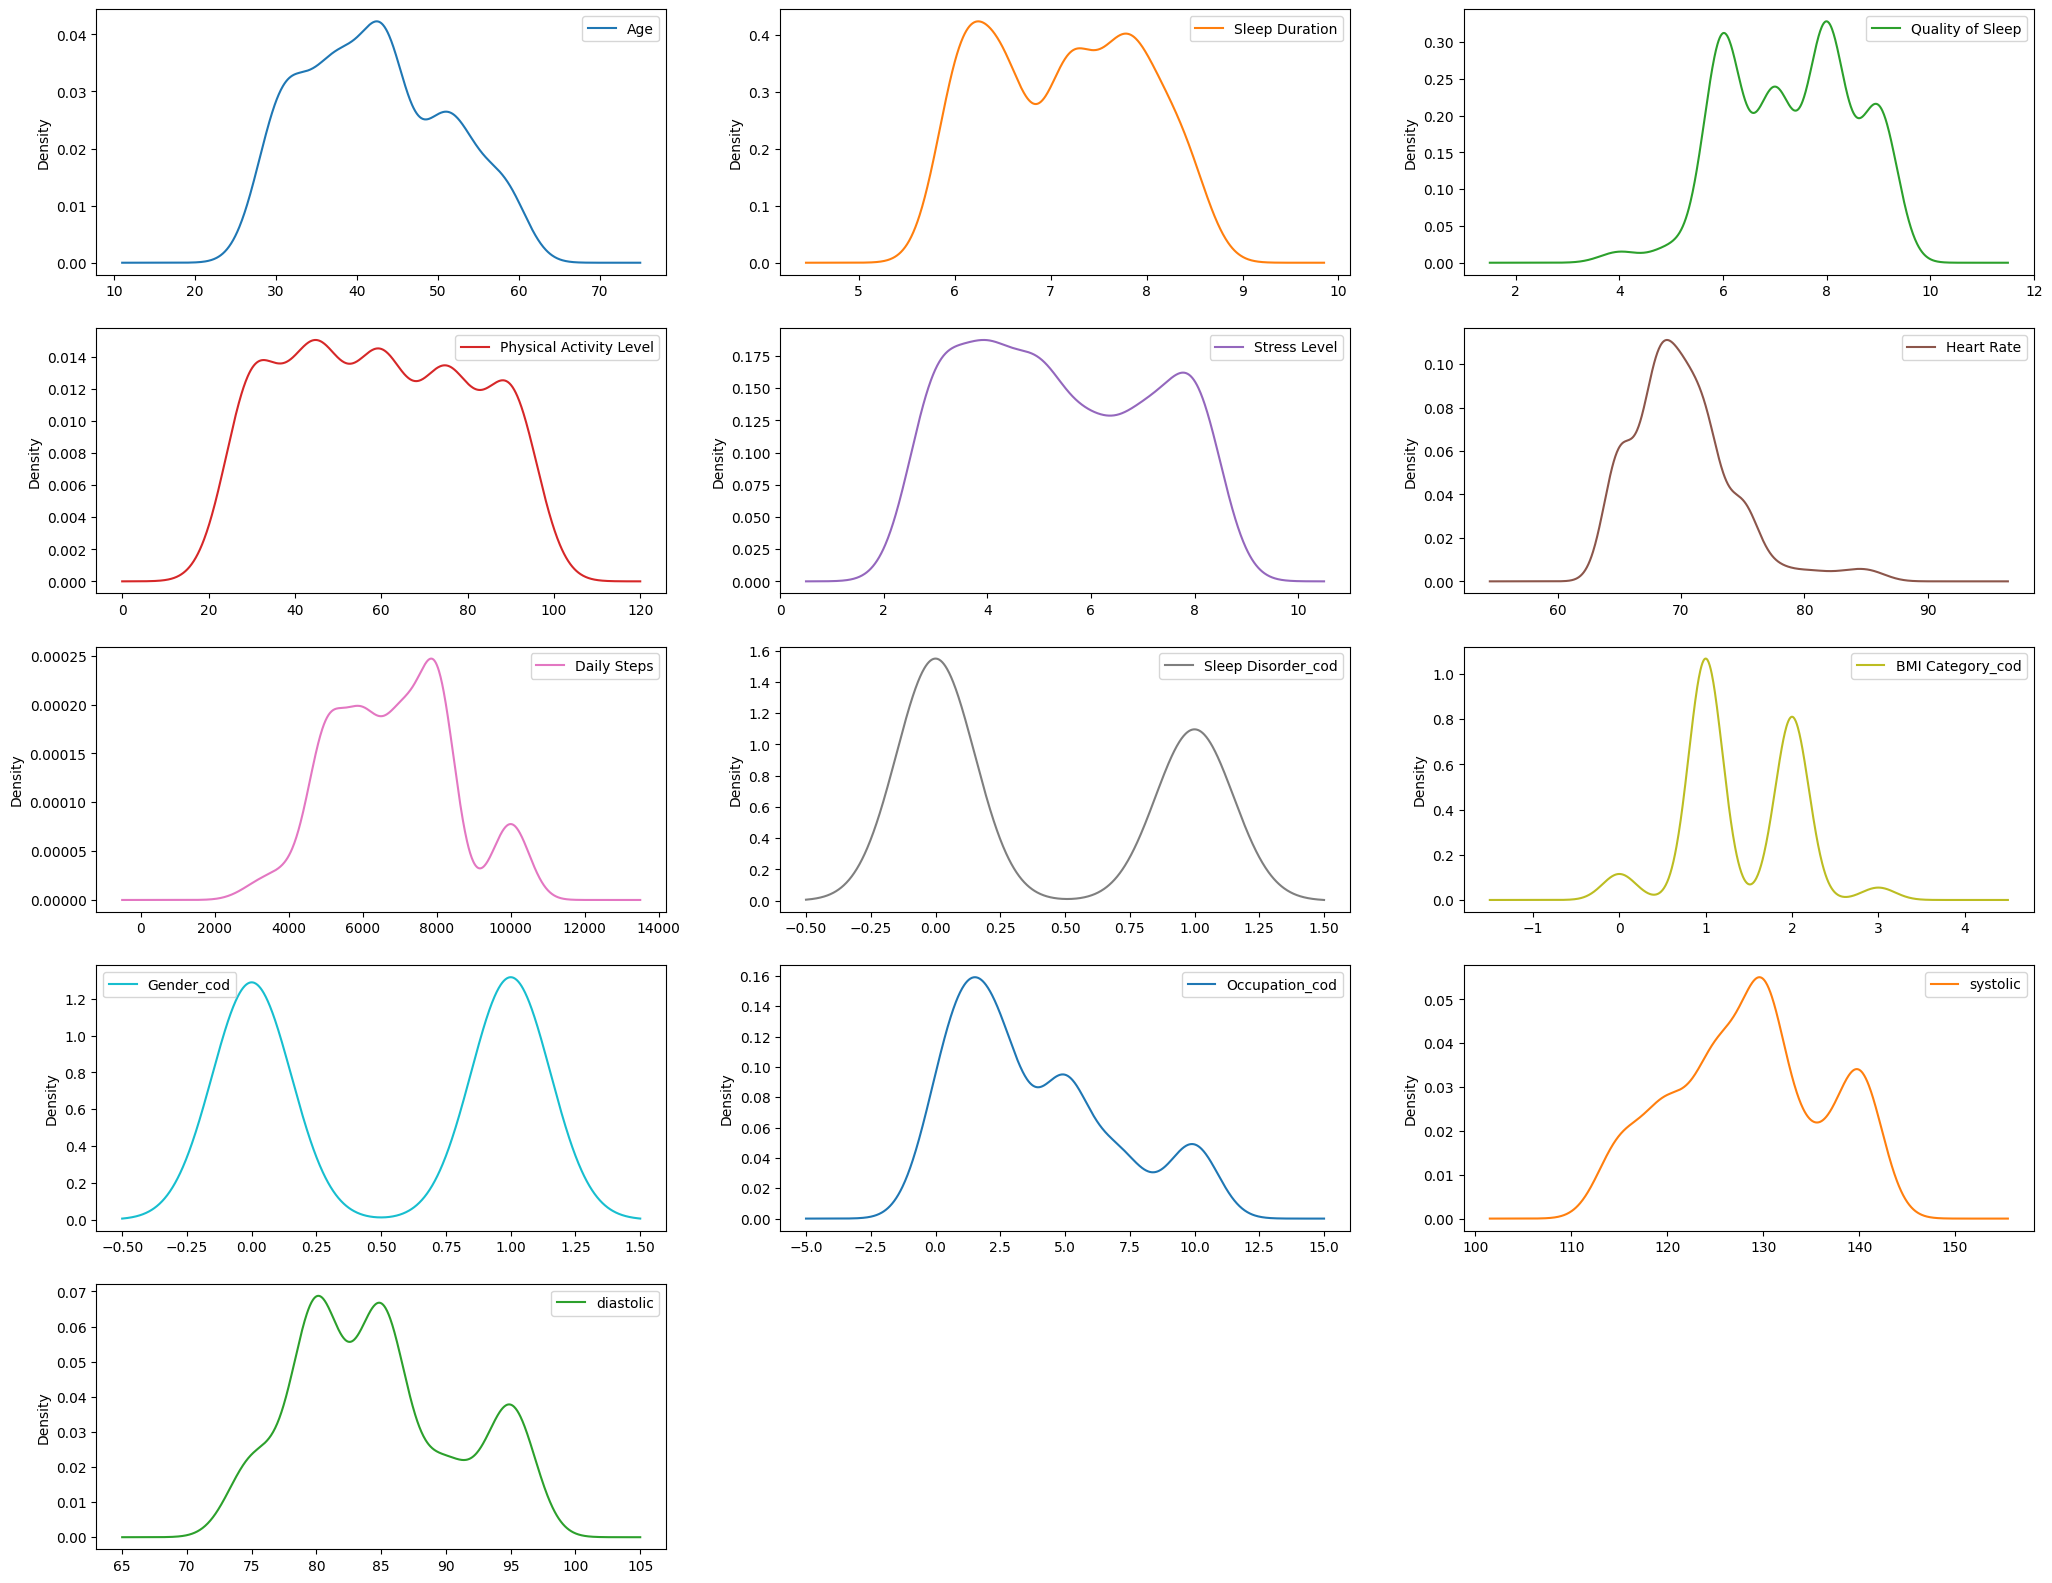

In [21]:
df_numericas = df.select_dtypes(include=[np.number])

df_numericas.hist(figsize=(25, 20))
plt.show()

df_numericas.plot(kind='density', subplots=True, layout=(5,3), sharex=False, figsize=(25, 20))
plt.show()

In [22]:
df.describe()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder_cod,BMI Category_cod,Gender_cod,Occupation_cod,systolic,diastolic
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920,0.414439,1.393048,0.505348,3.772727,128.553476,84.649733
std,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679,0.493285,0.636727,0.500641,3.056081,7.748118,6.161611
min,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,115.000000,75.000000
25%,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000,0.000000,1.000000,0.000000,1.000000,125.000000,80.000000
50%,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000,0.000000,1.000000,1.000000,3.000000,130.000000,85.000000
75%,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000,1.000000,2.000000,1.000000,5.000000,135.000000,90.000000
max,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000,1.000000,3.000000,1.000000,10.000000,142.000000,95.000000


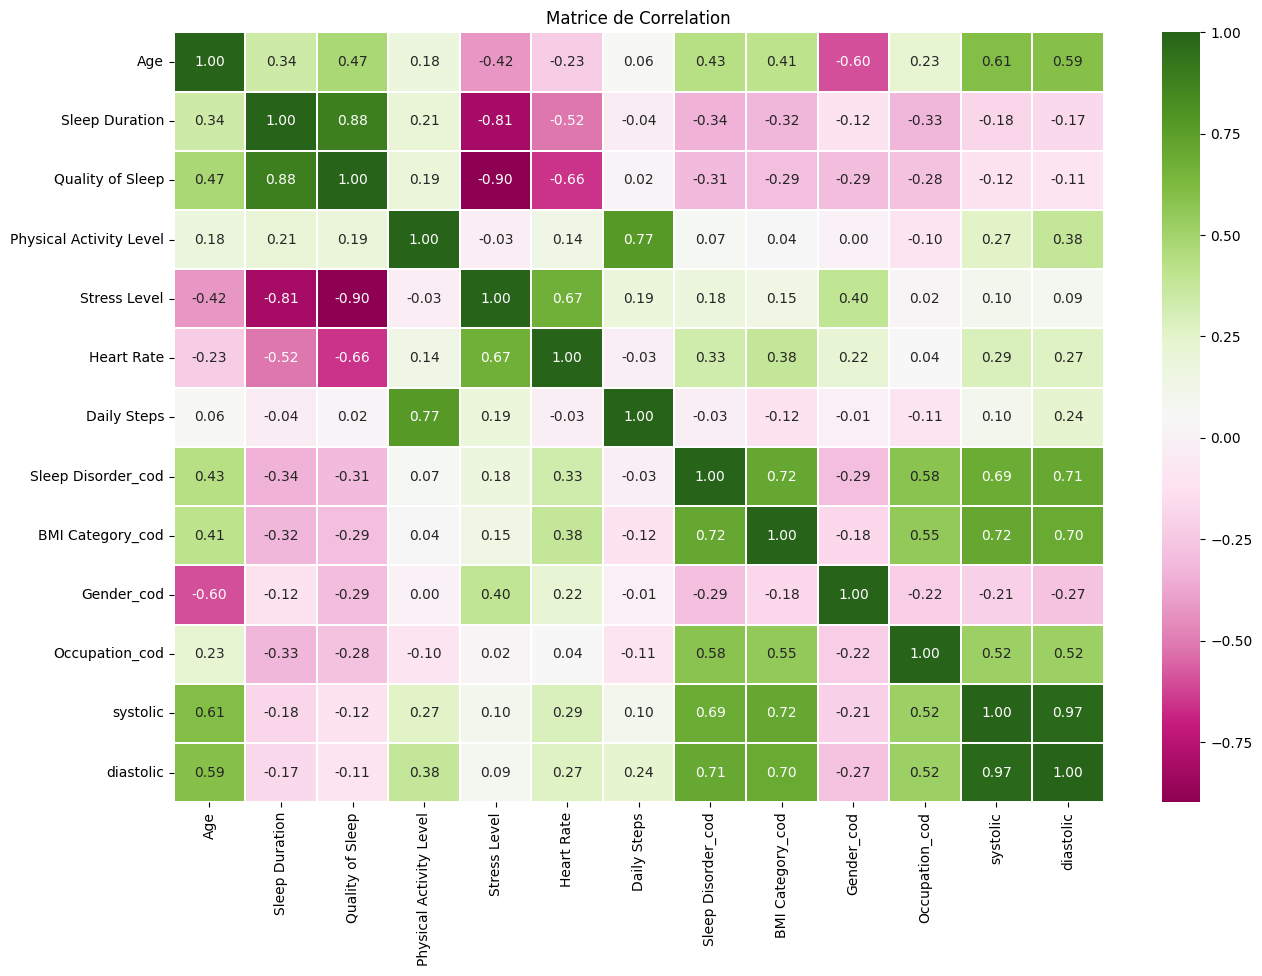

In [27]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap="PiYG", fmt=".2f", linewidths=.3)
plt.title("Matrice de Correlation")
plt.show()

In [28]:
X = df.drop(columns=['Sleep Disorder_cod'])
Y = df['Sleep Disorder_cod']

In [29]:
print(X.head())

   Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   27             6.1                 6                       42   
1   28             6.2                 6                       60   
2   28             6.2                 6                       60   
3   28             5.9                 4                       30   
4   28             5.9                 4                       30   

   Stress Level  Heart Rate  Daily Steps  BMI Category_cod  Gender_cod  \
0             6          77         4200                 2           1   
1             8          75        10000                 1           1   
2             8          75        10000                 1           1   
3             8          85         3000                 3           1   
4             8          85         3000                 3           1   

   Occupation_cod  systolic  diastolic  
0               9       126         83  
1               1       125         80  
2               1

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [32]:
dt = DecisionTreeClassifier(random_state=15, max_depth=4)
dt.fit(X_train, Y_train)
dt.fit(X_val,Y_val)

DecisionTreeClassifier(max_depth=4, random_state=15)

In [35]:
for i, column in enumerate(X_train.columns):
    print(f"x[{i}] -> {column}")

x[0] -> Age
x[1] -> Sleep Duration
x[2] -> Quality of Sleep
x[3] -> Physical Activity Level
x[4] -> Stress Level
x[5] -> Heart Rate
x[6] -> Daily Steps
x[7] -> BMI Category_cod
x[8] -> Gender_cod
x[9] -> Occupation_cod
x[10] -> systolic
x[11] -> diastolic


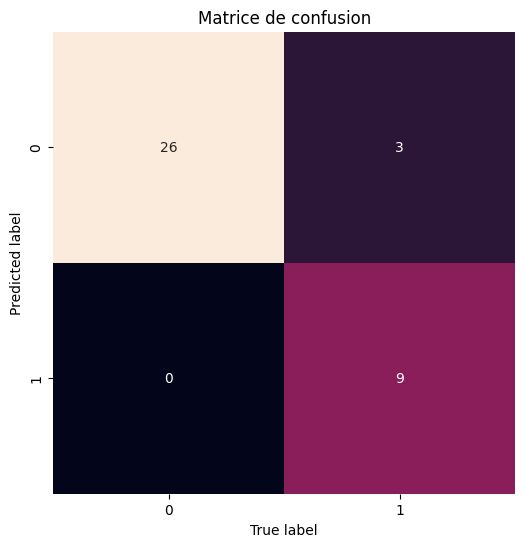

In [37]:
Y_pred = dt.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Matrice de confusion')
plt.show()

In [38]:
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Accuracy:", accuracy_score(Y_test, Y_pred))

F1 Score: 0.9012987012987013
Recall: 0.875
Precision: 0.9482758620689655
Accuracy: 0.9210526315789473


In [39]:
from sklearn.metrics import classification_report

accuracy = accuracy_score(Y_test, Y_pred)*100
print(f'Accuracy: {accuracy:.4f}')

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

Accuracy: 92.1053

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       1.00      0.75      0.86        12

    accuracy                           0.92        38
   macro avg       0.95      0.88      0.90        38
weighted avg       0.93      0.92      0.92        38



In [40]:
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y)

smote_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                         pd.DataFrame(Y_resampled, columns=["Sleep Disorder_cod"])], axis=1)
Y_resampled.value_counts()

Sleep Disorder_cod
0    219
1    219
Name: count, dtype: int64

In [41]:
X_train_smote, X_test_smote, Y_train_smote, Y_test_smote = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)


In [42]:

pipeline1 = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", DecisionTreeClassifier(random_state=42))])

pipeline1.fit(X_train_smote, Y_train_smote)
Y_pred_smote = pipeline1.predict(X_test_smote)

print("Accuracy:", accuracy_score(Y_test_smote, Y_pred_smote))

Accuracy: 0.9090909090909091


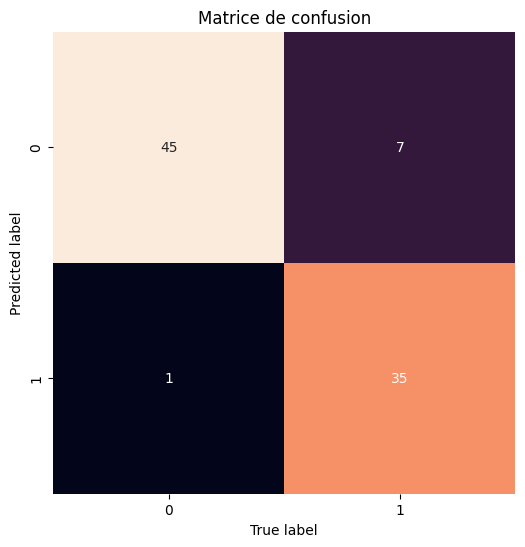

In [44]:
cm = confusion_matrix(Y_test_smote, Y_pred_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=set(Y_test_smote), yticklabels=set(Y_test_smote))
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Matrice de confusion')
plt.show()

In [45]:
print("Classification Report:\n", classification_report(Y_test_smote, Y_pred_smote))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92        46
           1       0.97      0.83      0.90        42

    accuracy                           0.91        88
   macro avg       0.92      0.91      0.91        88
weighted avg       0.92      0.91      0.91        88



In [46]:
pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

pipeline_knn.fit(X_train_smote, Y_train_smote)
Y_pred_knn = pipeline_knn.predict(X_test_smote)

print("Accuracy:", accuracy_score(Y_test_smote, Y_pred_knn))
print("\nClassification Report:\n", classification_report(Y_test_smote, Y_pred_knn))

Accuracy: 0.9318181818181818

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        46
           1       0.95      0.90      0.93        42

    accuracy                           0.93        88
   macro avg       0.93      0.93      0.93        88
weighted avg       0.93      0.93      0.93        88



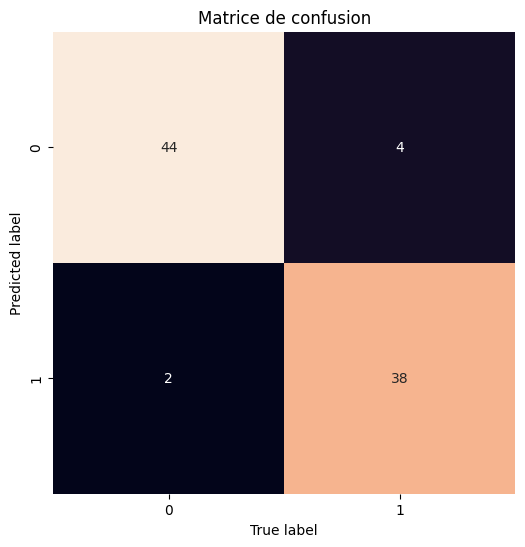

In [48]:
cm = confusion_matrix(Y_test_smote, Y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=set(Y_test_smote), yticklabels=set(Y_test_smote))
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Matrice de confusion')
plt.show()

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)

In [50]:
%%time
param_grid_pipeline1 = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

grid_pipeline1 = GridSearchCV(
    pipeline1, param_grid_pipeline1, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)
grid_pipeline1.fit(X_train, Y_train)

print("Best Parameters for Decision Tree (Pipeline 1):", grid_pipeline1.best_params_)
print("Best Cross-Validation Accuracy for Decision Tree:", grid_pipeline1.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree (Pipeline 1): {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best Cross-Validation Accuracy for Decision Tree: 0.9400000000000001
CPU times: total: 156 ms
Wall time: 1.66 s


In [51]:
%%time
param_grid_pipeline_knn = {
    "classifier__n_neighbors": [3, 5, 7, 10],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan"]
}

grid_pipeline_knn = GridSearchCV(
    pipeline_knn, param_grid_pipeline_knn, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)
grid_pipeline_knn.fit(X_train, Y_train)

print("Best Parameters for KNN (Pipeline KNN):", grid_pipeline_knn.best_params_)
print("Best Cross-Validation Accuracy for KNN:", grid_pipeline_knn.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for KNN (Pipeline KNN): {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Best Cross-Validation Accuracy for KNN: 0.9257142857142858
CPU times: total: 46.9 ms
Wall time: 73.6 ms


In [53]:
%%time
param_random_pipeline1 = {
    "classifier__max_depth": [3, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

pipeline1 = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

random_search_pipeline1 = RandomizedSearchCV(
    estimator=pipeline1,
    param_distributions=param_random_pipeline1,
    n_iter=20,
    cv=5,  # Cross-validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_pipeline1.fit(X_train, Y_train)

print("Best Parameters for Decision Tree (Pipeline 1):", random_search_pipeline1.best_params_)
print("Best Cross-Validation Accuracy for Decision Tree:", random_search_pipeline1.best_score_)

best_model_pipeline1 = random_search_pipeline1.best_estimator_
Y_pred_test_pipeline1 = best_model_pipeline1.predict(X_test)

print("\nTest Accuracy for Decision Tree:", accuracy_score(Y_test, Y_pred_test_pipeline1))
print("Classification Report for Decision Tree:\n", classification_report(Y_test, Y_pred_test_pipeline1))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Decision Tree (Pipeline 1): {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5}
Best Cross-Validation Accuracy for Decision Tree: 0.9400000000000001

Test Accuracy for Decision Tree: 0.9090909090909091
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92        46
           1       0.97      0.83      0.90        42

    accuracy                           0.91        88
   macro avg       0.92      0.91      0.91        88
weighted avg       0.92      0.91      0.91        88

CPU times: total: 62.5 ms
Wall time: 95 ms


In [55]:
%%time
param_random_pipeline_knn = {
    "classifier__n_neighbors": [3, 5, 7, 10],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan"]
}

pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", KNeighborsClassifier())
])

random_search_pipeline_knn = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_random_pipeline_knn,
    n_iter=20,
    cv=5,  # cross-validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_pipeline_knn.fit(X_train, Y_train)

print("Best Parameters for KNN (Pipeline KNN):", random_search_pipeline_knn.best_params_)
print("Best Cross-Validation Accuracy for KNN:", random_search_pipeline_knn.best_score_)

best_model_pipeline_knn = random_search_pipeline_knn.best_estimator_
Y_pred_test_pipeline_knn = best_model_pipeline_knn.predict(X_test)

print("\nTest Accuracy for KNN:", accuracy_score(Y_test, Y_pred_test_pipeline_knn))
print("Classification Report for KNN:\n", classification_report(Y_test, Y_pred_test_pipeline_knn))

best_model_pipeline_knn = random_search_pipeline_knn.best_estimator_
Y_pred_test_pipeline_knn = best_model_pipeline_knn.predict(X_test)

print("\nTest Accuracy for KNN:", accuracy_score(Y_test, Y_pred_test_pipeline_knn))
print("Classification Report for KNN:\n", classification_report(Y_test, Y_pred_test_pipeline_knn))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for KNN (Pipeline KNN): {'classifier__weights': 'uniform', 'classifier__n_neighbors': 5, 'classifier__metric': 'manhattan'}
Best Cross-Validation Accuracy for KNN: 0.9257142857142858

Test Accuracy for KNN: 0.9318181818181818
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        46
           1       0.95      0.90      0.93        42

    accuracy                           0.93        88
   macro avg       0.93      0.93      0.93        88
weighted avg       0.93      0.93      0.93        88


Test Accuracy for KNN: 0.9318181818181818
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        46
           1       0.95      0.90      0.93        42

    accuracy                           0.93        88
   macro avg       0.93      0.93      0.93  

C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [56]:
param_random_pipeline_rf = {
    "classifier__n_estimators": [50, 100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False]
}

pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(random_state=42))
])

random_search_pipeline_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_random_pipeline_rf,
    n_iter=20,  # Number of random combinations to test
    cv=5,  # Cross-validation
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_pipeline_rf.fit(X_train, Y_train)

print("Best Parameters for Random Forest (Pipeline RF):", random_search_pipeline_rf.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", random_search_pipeline_rf.best_score_)

best_model_pipeline_rf = random_search_pipeline_rf.best_estimator_
Y_pred_test_pipeline_rf = best_model_pipeline_rf.predict(X_test)

print("\nTest Accuracy for Random Forest:", accuracy_score(Y_test, Y_pred_test_pipeline_rf))
print("Classification Report for Random Forest:\n", classification_report(Y_test, Y_pred_test_pipeline_rf))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Random Forest (Pipeline RF): {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best Cross-Validation Accuracy for Random Forest: 0.9428571428571428

Test Accuracy for Random Forest: 0.9431818181818182
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95        46
           1       0.97      0.90      0.94        42

    accuracy                           0.94        88
   macro avg       0.95      0.94      0.94        88
weighted avg       0.95      0.94      0.94        88



In [57]:
from sklearn.linear_model import LogisticRegression

param_random_pipeline_lr = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear", "saga"]
}

pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1500, random_state=42))
])

random_search_pipeline_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=param_random_pipeline_lr,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=5,  # Validación cruzada
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_pipeline_lr.fit(X_train, Y_train)

print("Best Parameters for Logistic Regression (Pipeline LR):", random_search_pipeline_lr.best_params_)
print("Best Cross-Validation Accuracy for Logistic Regression:", random_search_pipeline_lr.best_score_)

best_model_pipeline_lr = random_search_pipeline_lr.best_estimator_
Y_pred_test_pipeline_lr = best_model_pipeline_lr.predict(X_test)

print("\nTest Accuracy for Logistic Regression:", accuracy_score(Y_test, Y_pred_test_pipeline_lr))
print("Classification Report for Logistic Regression:\n", classification_report(Y_test, Y_pred_test_pipeline_lr))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Logistic Regression (Pipeline LR): {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 0.01}
Best Cross-Validation Accuracy for Logistic Regression: 0.9171428571428573

Test Accuracy for Logistic Regression: 0.9204545454545454
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        46
           1       0.93      0.90      0.92        42

    accuracy                           0.92        88
   macro avg       0.92      0.92      0.92        88
weighted avg       0.92      0.92      0.92        88



In [61]:
colum=["dataset", "balancing?", "Target Variable", "balancing technique", "algorithm", "parameters", "validation technique", "accuracy"]


data = np.array([['Sleep Disorder','Y','Sleep Disorder','SMOTE','Decision Tree','random_state=42',"simple validation",'0.9167'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','KNN','n_neighbors=5',"simple validation",'0.9015'],
                 ['Sleep Disorder','Y','Sleep Disorder','Undersampling','Decision Tree','random_state=42',"simple validation",'0.7659'],
                 ['Sleep Disorder','Y','Sleep Disorder','Undersampling','KNN','n_neighbors=5',"simple validation",'0.7234'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','Decision Tree','classifier__max_depth: 5, classifier__min_samples_leaf: 1, classifier__min_samples_split: 2',"Cross-Validation",'0.9242'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','KNN','classifier__metric: manhattan, classifier__n_neighbors: 3, classifier__weights: uniform',"Cross-Validation",'0.8912'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','Decision Tree','classifier__min_samples_split: 2, classifier__min_samples_leaf: 1, classifier__max_depth: 5',"Cross-Validation",'0.9242'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','KNN','classifier__weights: distance, classifier__n_neighbors: 3, classifier__metric: manhattan',"Cross-Validation",'0.9394'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','Random Forest','classifier__n_estimators: 100, classifier__min_samples_split: 2, classifier__min_samples_leaf: 2, classifier__max_depth: None, classifier__bootstrap: False',"Cross-Validation",'0.9318'],
                 ['Sleep Disorder','Y','Sleep Disorder','SMOTE','Logistic Regression','classifier__solver: saga, classifier__penalty: l2, classifier__C: 10',"Cross-Validation",'0.9105']])



df = pd.DataFrame(data, columns=colum)
df.head(10)


,dataset,balancing?,Target Variable,balancing technique,algorithm,parameters,validation technique,accuracy
0,Sleep Disorder,Y,Sleep Disorder,SMOTE,Decision Tree,random_state=42,simple validation,0.9167
1,Sleep Disorder,Y,Sleep Disorder,SMOTE,KNN,n_neighbors=5,simple validation,0.9015
2,Sleep Disorder,Y,Sleep Disorder,Undersampling,Decision Tree,random_state=42,simple validation,0.7659
3,Sleep Disorder,Y,Sleep Disorder,Undersampling,KNN,n_neighbors=5,simple validation,0.7234
4,Sleep Disorder,Y,Sleep Disorder,SMOTE,Decision Tree,"classifier__max_depth: 5, classifier__min_samp...",Cross-Validation,0.9242
5,Sleep Disorder,Y,Sleep Disorder,SMOTE,KNN,"classifier__metric: manhattan, classifier__n_n...",Cross-Validation,0.8912
6,Sleep Disorder,Y,Sleep Disorder,SMOTE,Decision Tree,"classifier__min_samples_split: 2, classifier__...",Cross-Validation,0.9242
7,Sleep Disorder,Y,Sleep Disorder,SMOTE,KNN,"classifier__weights: distance, classifier__n_n...",Cross-Validation,0.9394
8,Sleep Disorder,Y,Sleep Disorder,SMOTE,Random Forest,"classifier__n_estimators: 100, classifier__min...",Cross-Validation,0.9318
9,Sleep Disorder,Y,Sleep Disorder,SMOTE,Logistic Regression,"classifier__solver: saga, classifier__penalty:...",Cross-Validation,0.9105


In [62]:
models = {
    'Logistic Regression': LogisticRegression(solver='saga', penalty='l2', C=10),
    'Random Forest': RandomForestClassifier(n_estimators= 100, min_samples_split=2, min_samples_leaf= 2, max_depth= None, bootstrap=False),
    'Decision Tree': DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf=1, max_depth= 5),
    'K-Nearest Neighbors': KNeighborsClassifier(weights= 'distance', n_neighbors=3, metric= 'manhattan')
}

results = []
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

df_results = pd.DataFrame(results)
print(df_results)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.625000   0.626744  0.625000  0.625145
1        Random Forest  0.943182   0.945091  0.943182  0.943027
2        Decision Tree  0.909091   0.916375  0.909091  0.908377
3  K-Nearest Neighbors  0.909091   0.916375  0.909091  0.908377


C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [64]:
for name, model in models.items():
    y_pred = model.predict(X_test)

    cm = confusion_matrix(Y_test, y_pred)

    print(f"Matrice de confusion pour {name}:")
    print(cm)
    print("\n")

Matrice de confusion pour Logistic Regression:
[[28 18]
 [15 27]]


Matrice de confusion pour Random Forest:
[[45  1]
 [ 4 38]]


Matrice de confusion pour Decision Tree:
[[45  1]
 [ 7 35]]


Matrice de confusion pour K-Nearest Neighbors:
[[45  1]
 [ 7 35]]




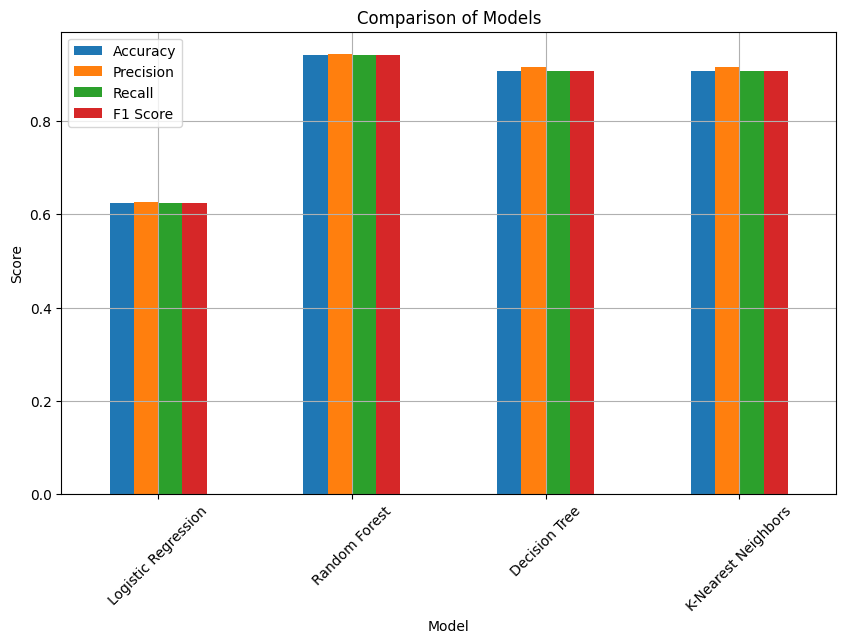

In [65]:
df_results.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

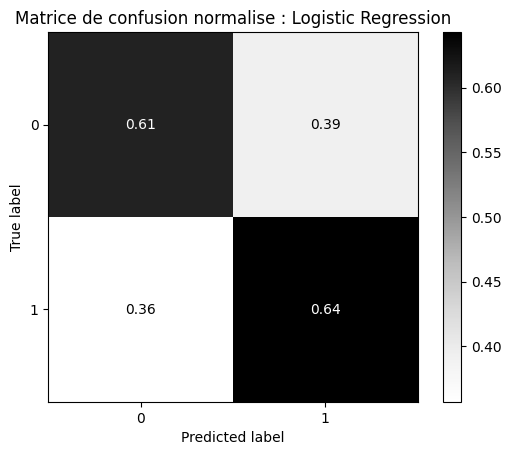

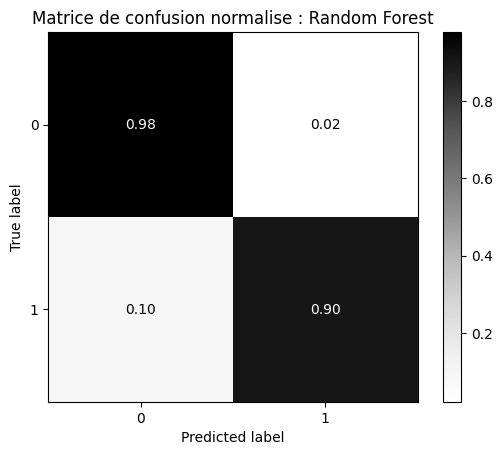

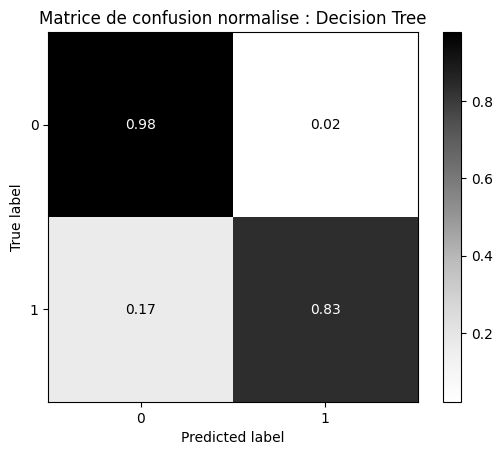

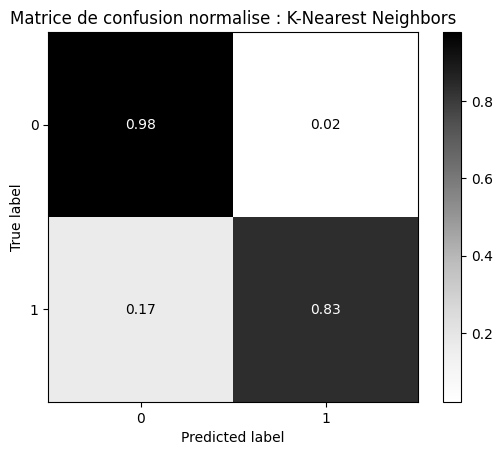

In [67]:
for name, model in models.items():
    y_pred = model.predict(X_test)

    cm_normalized = confusion_matrix(Y_test, y_pred, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)
    disp.plot(cmap='Greys', values_format='.2f')
    plt.title(f'Matrice de confusion normalise : {name}')
    plt.show()

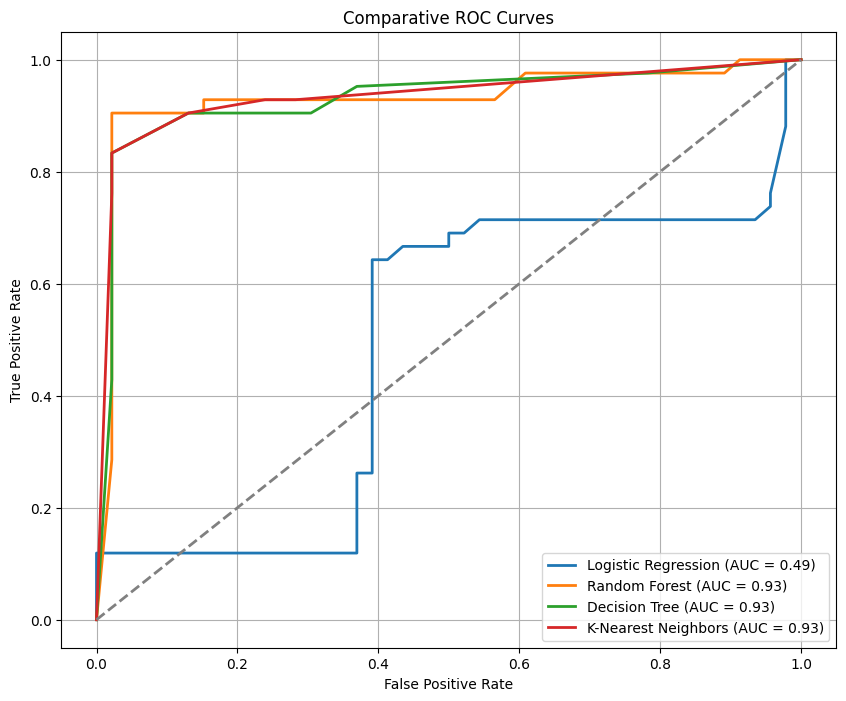

In [68]:

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_prob)  # Use Y_test directly
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves')
plt.legend(loc='lower right')
plt.grid()


In [69]:
bag_clf = BaggingClassifier(
    RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=None, bootstrap=False),
    n_estimators=500,
    max_samples=0.8,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, Y_train)
y_train_tree = bag_clf.predict(X_train)
print("Accuracy on the training set:", accuracy_score(Y_train, y_train_tree))

y_pred = bag_clf.predict(X_test)
print("Accuracy on the test set:", accuracy_score(Y_test, y_pred))

precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}, \nRecall: {recall:.2f}")

f1 = f1_score(Y_test, y_pred, average='weighted')  # Change the average if necessary
print(f"F1-Score: {f1:.2f}")

Accuracy on the training set: 0.9457142857142857
Accuracy on the test set: 0.9431818181818182
Precision: 0.95, 
Recall: 0.94
F1-Score: 0.94


In [70]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

ada_clf.fit(X_train, Y_train)
y_pred_train = ada_clf.predict(X_train)
y_pred_test = ada_clf.predict(X_test)

print("Accuracy on the training set:", accuracy_score(Y_train, y_pred_train))

print("Accuracy on the test set:", accuracy_score(Y_test, y_pred_test))

precision = precision_score(Y_test, y_pred_test, average='weighted')
recall = recall_score(Y_test, y_pred_test, average='weighted')
print(f"Precision: {precision:.2f}, \nRecall: {recall:.2f}")

f1 = f1_score(Y_test, y_pred_test, average='weighted')  # Change the average if necessary
print(f"F1-Score: {f1:.2f}")


C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy on the training set: 0.9571428571428572
Accuracy on the test set: 0.8863636363636364
Precision: 0.89, 
Recall: 0.89
F1-Score: 0.89


In [71]:
level0 = list()
level0.append(('knn', KNeighborsClassifier(weights='distance', n_neighbors=3, metric='manhattan')))
level0.append(('dt', DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5)))
level0.append(('rf', RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_depth=None, bootstrap=False)))

level1 = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='sgd',
)

models = {
    'Logistic Regression': LogisticRegression(solver='saga', penalty='l2', C=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=None, bootstrap=False),
    'Decision Tree': DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5),
    'K-Nearest Neighbors': KNeighborsClassifier(weights='distance', n_neighbors=3, metric='manhattan'),
    'Bagging': BaggingClassifier(RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=None, bootstrap=False),
                                  n_estimators=500, max_samples=0.8, bootstrap=True, bootstrap_features=False, n_jobs=-1, random_state=42),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5), n_estimators=200,
                                   learning_rate=0.1, random_state=42),
    'Stacking': StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
}

results = []
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

df_results = pd.DataFrame(results)
print(df_results)


C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.625000   0.626744  0.625000  0.625145
1        Random Forest  0.943182   0.945091  0.943182  0.943027
2        Decision Tree  0.909091   0.916375  0.909091  0.908377
3  K-Nearest Neighbors  0.909091   0.916375  0.909091  0.908377
4              Bagging  0.943182   0.945091  0.943182  0.943027
5             AdaBoost  0.886364   0.887397  0.886364  0.886422
6             Stacking  0.886364   0.887397  0.886364  0.886422


C:\Users\walmo\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


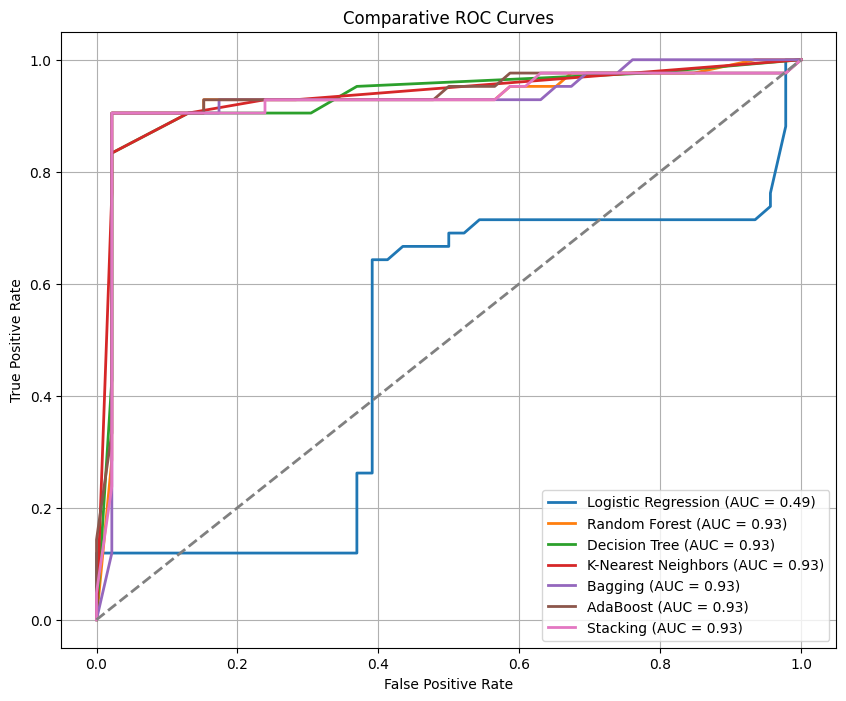

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_prob) # Use Y_test directly
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

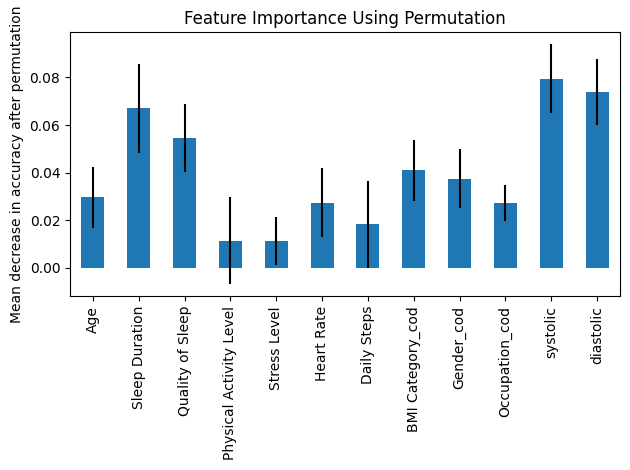

In [73]:
result = permutation_importance(ada_clf, X_test, Y_test, n_repeats=10, random_state=0)
importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)  # Include standard deviation in the figure
ax.set_title("Feature Importance Using Permutation")
ax.set_ylabel("Mean decrease in accuracy after permutation")
fig.tight_layout()
plt.show()


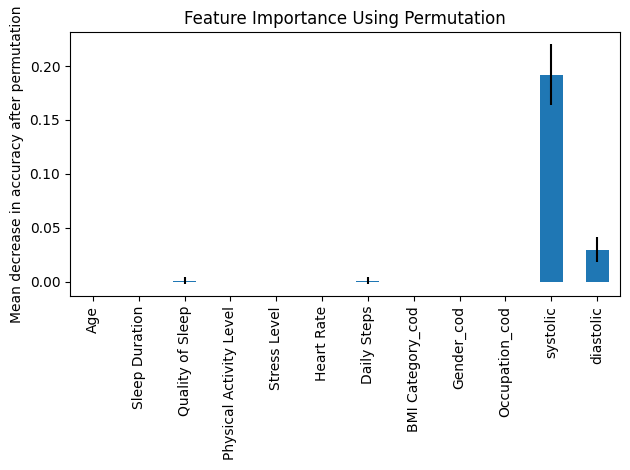

In [74]:
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_depth=None, bootstrap=False)
rf_clf.fit(X_train, Y_train)

result = permutation_importance(rf_clf, X_test, Y_test, n_repeats=10, random_state=0)
importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)  # Include standard deviation in the figure
ax.set_title("Feature Importance Using Permutation")
ax.set_ylabel("Mean decrease in accuracy after permutation")
fig.tight_layout()
plt.show()


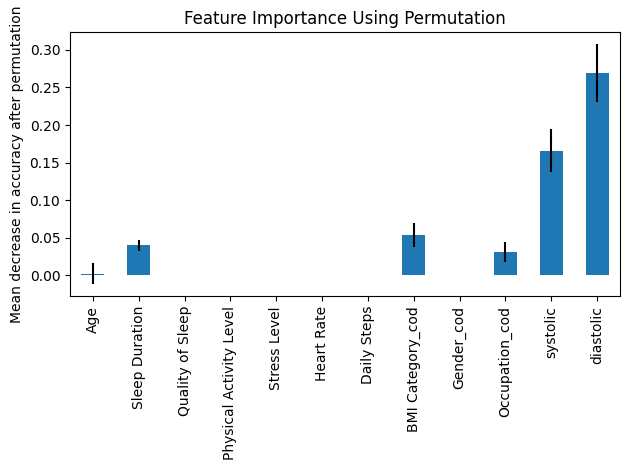

In [75]:
dt = DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1, max_depth=5)
dt.fit(X_train, Y_train)

result = permutation_importance(dt, X_test, Y_test, n_repeats=10, random_state=0)
importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)  # Include standard deviation in the figure
ax.set_title("Feature Importance Using Permutation")
ax.set_ylabel("Mean decrease in accuracy after permutation")
fig.tight_layout()
plt.show()
